In [1]:
# imports
import pandas as pd
import numpy as np
import os

In [2]:
import kagglehub
path = kagglehub.dataset_download("fatemehmehrparvar/obesity-levels")
csv_file_path = os.path.join(path, "ObesityDataSet_raw_and_data_sinthetic.csv") 
print("Path to dataset files:", path)

/Users/kierstenwener/Desktop/MLLab5-2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/kierstenwener/.cache/kagglehub/datasets/fatemehmehrparvar/obesity-levels/versions/1


In [3]:
df = pd.read_csv(csv_file_path) #can infer col names
df.head()


,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,Normal_Weight
1,21.0,Female,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,23.0,Male,1.80,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,Normal_Weight
3,27.0,Male,1.80,87.0,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking,Overweight_Level_I
4,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   object 
 12  FAF                             21

In [5]:
num_classes = df['FAVC'].nunique()
print(f'Num classes {num_classes}')

Num classes 2


In [6]:
drink = df['TUE'].value_counts()
print(drink)

TUE
0.000000    557
1.000000    292
2.000000    109
0.630866      4
1.119877      3
           ... 
1.343044      1
1.019452      1
0.673408      1
0.997600      1
0.714137      1
Name: count, Length: 1129, dtype: int64


In [7]:
class_distrib = df['NObeyesdad'].value_counts()
print(class_distrib)

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


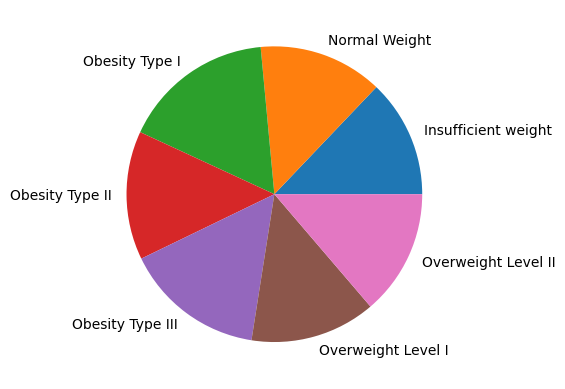

In [8]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

tmp = LabelEncoder()
y= tmp.fit_transform(df['NObeyesdad'])
class_labels = np.array(['Insufficient weight', 'Normal Weight', 'Obesity Type I', 'Obesity Type II', 'Obesity Type III', 'Overweight Level I', 'Overweight Level II'])
counts = np.bincount(y)
plt.pie(counts, labels = class_labels)
plt.show()

In [9]:
print(tmp.classes_)

['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = df.drop('NObeyesdad', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

You have to scale and encode after splitting i believe. if you dont, the encoder/scaler will also learn from the test data which should not happen. 

In [11]:
from sklearn.preprocessing import OneHotEncoder
#there are other numeric attributes, but they are discrete, not continuous 
#age, height, weight, NCP (num of meals per day), CH20 (how much water you drink daily), and FAF (how ofetn exercise) are the continuous numeric columns
#there are other numeric attributes, but they are discrete, not continuous 
scaler = StandardScaler()
cont_indices = [0, 2, 3, 7, 10, 12]
categorical_index = [i for i in range(X.shape[1]) if i not in cont_indices]
print("Number of columns in X:", X.shape[1])  # Ensure the number of columns in X is as expected
print("Continuous column indices:", cont_indices)

X = X.to_numpy()
X_scale = scaler.fit_transform(X[:, cont_indices])
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")
X_encoded = encoder.fit_transform(X[:, categorical_index])
X = np.hstack([X_scale, X_encoded])

#split for validation
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.20, random_state=1)
print(X.shape)
#Here, i fit the scaler only on the training data. I then apply that same scale on testing data. 
#This way, the X_test data doesnt change the scale that the data is scaled on, to prevent data snooping 
# X_train.iloc[:, cont_indices] = scaler.fit_transform(X_train.iloc[:, cont_indices])
# X_test.iloc[:, cont_indices] = scaler.transform(X_test.iloc[:, cont_indices])



# One-hot encoding for categorical features
# encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")
# X_train_cat_encoded = encoder.fit_transform(X_train[categorical_index])
# X_test_cat_encoded = encoder.transform(X_test[categorical_index])
# X_encoded = encoder.transform(X[categorical_index])

# Concatenate scaled continuous and encoded categorical features
# X_train= np.hstack([X_train.iloc[:, cont_indices], X_train_cat_encoded])
# X_test_final = np.hstack([X_test.iloc[:, cont_indices], X_test_cat_encoded])
# X= np.hstack([X_scale.iloc[:, cont_indices], X_encoded])

Number of columns in X: 16
Continuous column indices: [0, 2, 3, 7, 10, 12]
(2111, 1958)


dimensions are too large after one hot encoding, do PCA

At the end of preprocessing, the categorical variables are one hot encoded, the continuous variables are scaled, the target variable was integer encoded, and pca was done to reduce the number of features from 1567 to 200. This dataset is used for classification, as because the target variable is a categorical variable. The other attributes in the data set will be used to classify the tuple by one of the labels (classes of the target variable). These include 'Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II', 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II'.

In a business application, this classification model could be used for ....

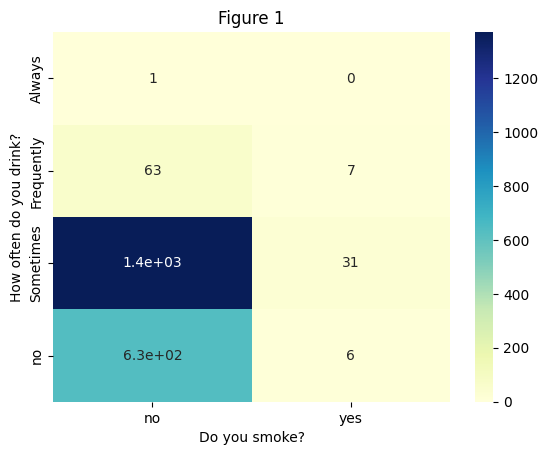

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
contingency_table = pd.crosstab(df['CALC'], df['SMOKE'])
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.xlabel('Do you smoke?')
plt.ylabel('How often do you drink?')
plt.title('Figure 1')
plt.show()

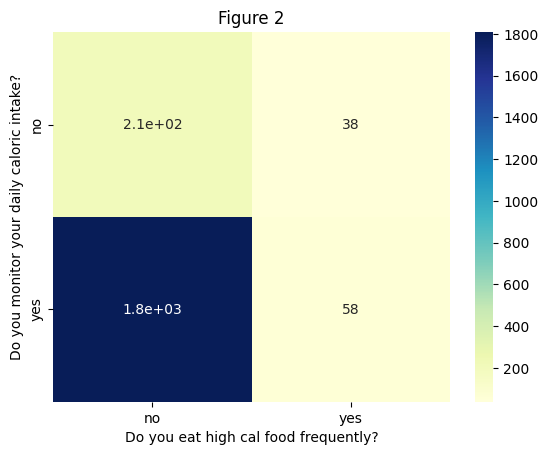

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
contingency_table = pd.crosstab(df['FAVC'], df['SCC'])
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.xlabel('Do you eat high cal food frequently?')
plt.ylabel('Do you monitor your daily caloric intake?')
plt.title('Figure 2')
plt.show()

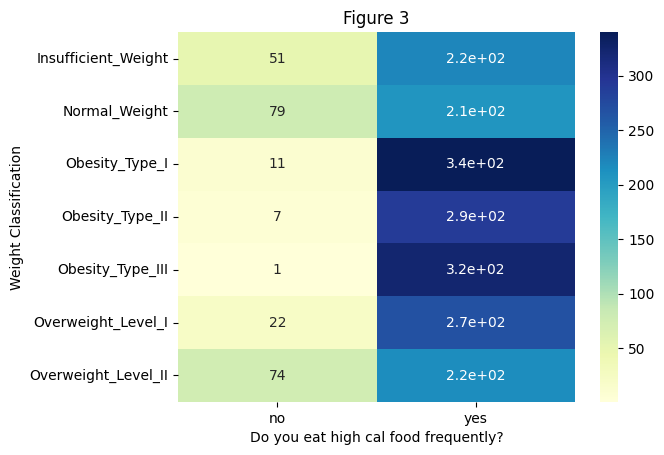

In [14]:
contingency_table = pd.crosstab(df['NObeyesdad'], df['FAVC'])
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu")
plt.xlabel('Do you eat high cal food frequently?')
plt.ylabel('Weight Classification')
plt.title('Figure 3')
plt.show()

https://developers.google.com/machine-learning/crash-course/categorical-data/feature-crosses

Try not to cross two sparse features, this would create a new sparser feature than the original elements 

I would recommend crossing SMOKE (Binary, do you smoke?) and CALC (How often do you drink alcohol with answer options including no, sometimes, frequently, always). Each of these features has a small number of classes, which will make computations easy. They are also pretty correlated. As you can see by the heatmap above (Figure 1), If a person does not smoke, it is highly likely that they either dont drink, or that they only drink sometimes. This combination captures the interaction between lifestyle patterns (smoking and drinking) that could be valuable in predicting other health ..., like if a person is obese.


I would also recommend crossing FAVC (Binary question:Do you eat high caloric food frequently? ) and SCC (Binary question, do you monitor the calories you eat daily?). Each is a binary question, meaning they will each have a yes or no answer, which makes the crossed feature simple. They also have a correlation. As you can see above, if a person does not eat high calorie food frequently, it is likely that they also monitor their caloric intake. This captures the interaction between a person being conscious of they caloric intake, and ...., its health consequences, and if a person eats high calorie food often. This interaction can provide useful insights to a person being conscious of their diet and its correlation with obesity, If a person is conscious about their health in a way that causes them to not eat high calorie foods, it is likely that they are conscious of/monitor their daily calorie intake. These two factors logically influence eachother, so it makes sense to combine them. 


If a person eats high caloric food frequently (FAVC) and has a family history of obesity (family_history_with_overweight), it greatly influences the odds that the person is obese, which is the classification task at hand. This is why it may be beneficial to combine family_history_with_overweight and FAVC. In Figure 2, you can also see a correlation between the variables. If a person has a family history of obesity, it is more likely that they eat high calorie food frequently. People often adpot the lifestyle habits that they observed growing up. If a person's family eats high calorie food growing up, which is HIGHLY correlated with obesity, it is likely that they will have similar dietary habits, and face similar consequences (Figure 3). 



This model performs a classifies a person by their obesity level based on attributes like gender, age, their lifestyle choices (if they drink/smoke and their ... sedintary), their diet, etc. In a business scenario, this model could be used by doctors offices (general practitioners/weight loss specialists) to predict if a person is at risk for being obese, and recommend lifestyle changes accordingly. Obesity can lead to serious health conseuqences, like heart disease, cancer, and type 2 diabetes, all of which can be fatal. If a person is on track to... obesity and the model fails to catch it, it could prevent a person from getting the intervention that they need to preserve their health. However, if the model misclassifies a person as obese when they are not, the recommended lifestyle changes wouldn't have a negative impact on the person. That being said false negatives have more serious implications than false positives. Because of this, we should use the recall metric. The recall metric measures the number of false negatives (the higher the recall, the lower the number of false neg), so we can be sure that our model is performing properly for the business application that we have in mind. 

To evaluate this algorithm's performance, 

#https://stackoverflow.com/questions/34731421/whats-the-difference-between-kfold-and-shufflesplit-cv#:~:text=KFold%20will%20divide%20your%20data,set%20and%20a%20test%20set.
use stratified for unbalanced


Based on the graph above the the figures above, we see that the data is realatively balanced. there is a relatively equal number of each class of the target variable in the data set. Even still, I will use stratified K-Fold to split the data. This will ensure that the folds maintain the original distribution of classes in the data to make sure that all of the classes are represented correctly.

The difference between kfold and shufflesplit is that kfold divides the data into a specific number of folds (each of which is a subset of the dataset) and shufflesplit randomly takes samples from your whole dataset to make a train and test set at each iteration. With shufflesplit, the test sets can overlap, where in kfold, they cant. To prevent overlap and any bias, I will use the kfold method. This also ensures that each data point will be used for testing, whereas in shufflesplit, it is possible that a datapoint will not be used for testing at all. The dataset is also on the smaller side with 2111 samples, so kfold won't be too computationally expensive and can be used. 

In [15]:
#have to split the data into testing and training before one hot encoding, normalizing, dimensionality reduction etc to prevent dats snooping
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Initialize stratified k-fold

pipe_rf = Pipeline([
                    ('pca', PCA(n_components=30,random_state=1)),
                    ('clf', RandomForestClassifier( random_state=1))])
# List to hold accuracy scores

kfold_for_validation = StratifiedKFold(n_splits=10).split(X_train1, y_train1)

scores = []
for k, (train, test) in enumerate(kfold_for_validation):
    pipe_rf.fit(X_train1[train], y_train1[train])
    score = pipe_rf.score(X_train1[test], y_train1[test])
    scores.append(score)
    print('Fold: %s, Acc: %.3f' % (k+1, score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.858
Fold: 2, Acc: 0.876
Fold: 3, Acc: 0.899
Fold: 4, Acc: 0.852
Fold: 5, Acc: 0.870
Fold: 6, Acc: 0.852
Fold: 7, Acc: 0.876
Fold: 8, Acc: 0.870
Fold: 9, Acc: 0.869
Fold: 10, Acc: 0.863

CV accuracy: 0.868 +/- 0.013


In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_rf,
                         X=X_train1,
                         y=y_train1,
                         cv=10,
                         n_jobs=-1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.85798817 0.87573964 0.89940828 0.85207101 0.86982249 0.85207101
 0.87573964 0.86982249 0.86904762 0.86309524]
CV accuracy: 0.868 +/- 0.013


In [17]:
def plot_filled(train_scores,test_scores,train_x_axis, xlabel=''):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =learning_curve(estimator=pipe_rf,
                                                       X=X_train1,
                                                       y=y_train1,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=5,
                                                       n_jobs=-1)

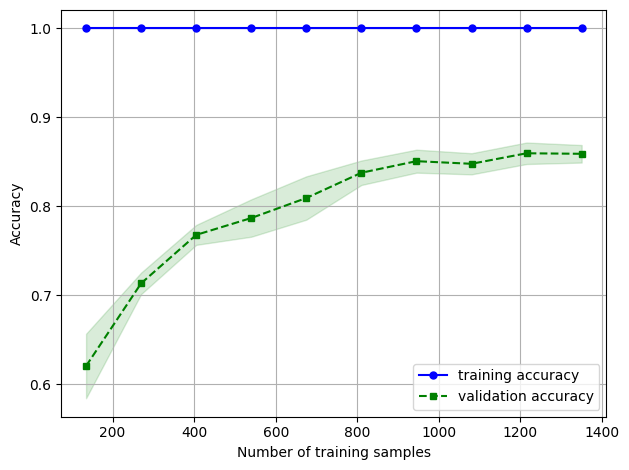

In [19]:
plot_filled(train_scores, test_scores, train_sizes, xlabel='Number of training samples')

Shows that it is overlearned

In [20]:
from sklearn.model_selection import validation_curve


param_name = 'clf__max_depth'
param_range = [5, 10, 15, 20]
train_scores, test_scores = validation_curve(
                estimator=pipe_rf, 
                X=X_train1, 
                y=y_train1, 
                param_name=param_name,
                param_range=param_range,
                cv=5,n_jobs=-1)

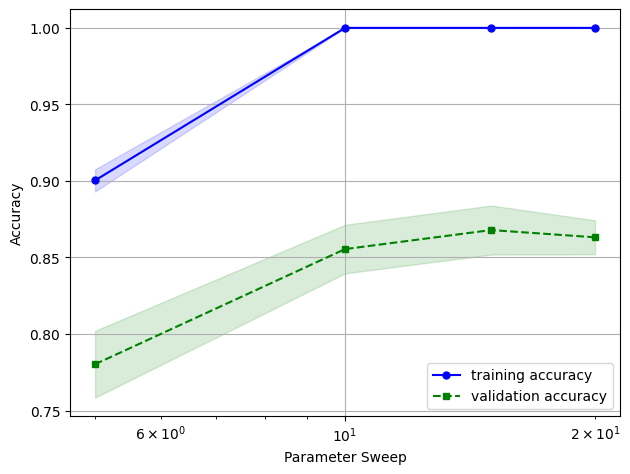

In [21]:
plot_filled(train_scores, test_scores, param_range, xlabel='Parameter Sweep')
plt.xscale('log')
plt.show()

The blue line represents the mean training accuracy across the cross validation for each of the values of max depth (the max depth of each tree). There is supposed to be a blue shading around it that represents 1 standard deviation from the mean. The high/stable training accuracy across folds that we see with the horizonal line at 1 indicates that the model fits the training data well.

The green line represents the mean validation accuracy across all folds for each max depth param. The shaded area shows the variability in the validation accuracy. The green line is lower than the blue line, but not significantly enough that we have to worry about overfitting. As far as parameter, I will choose 15, since that is where validation accuraxy seems stable

Start kfold split on whole dataset, not just for validation
this is to be used in the modeling

In [22]:
# kfold_for_validation = StratifiedKFold(n_splits=10).split(X, y)
# print(kfold_for_validation)

In [23]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import metrics as mt
#using venv, caused error with distutils, so added this line
import setuptools.dist
import tensorflow as tf
from tensorflow import keras
import sys

print(tf.__version__)
print(keras.__version__)
print(sys.version)

2.18.0
3.6.0
3.12.3 (main, Apr  9 2024, 16:03:47) [Clang 14.0.0 (clang-1400.0.29.202)]


In [24]:
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

In [25]:
print(X.shape)
print(y.shape)
# print(y)


(2111, 1958)
(2111,)


Model Deep and Wide 1
    This model has 3 deep layers and one wide layer

In [ ]:
cols_list = ['marital_status','workclass','relationship']

# 1. create crossed labels by string join operation
X_crossed_train = X[cols_list].apply(lambda x: '_'.join(x), axis=1)
X_crossed_test = X[cols_list].apply(lambda x: '_'.join(x), axis=1)

# combine together for training
all_vals = np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy()))
print(np.unique(all_vals))
    
# 2. encode as integers, stacking all possibilities
enc = LabelEncoder()
enc.fit(all_vals)

encoded_vals_train = enc.transform(X_crossed_train)
encoded_vals_test  = enc.transform(X_crossed_test)

print(np.min(encoded_vals_train), np.max(encoded_vals_train))

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Function to create Keras model
def create_wide_deep_model1(input_dim):
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Wide part (shallow model, might just be one dense layer)
    wide_layer = Dense(32, activation='linear')(input_layer)
    
    # Deep part (deeper neural network with more layers)
    deep_layer = Dense(128, activation='relu')(input_layer)
    deep_layer = Dense(64, activation='relu')(deep_layer)
    deep_layer = Dense(32, activation='relu')(deep_layer)
    
    # Combine the wide and deep parts (concatenate)
    combined = layers.add([wide_layer, deep_layer])

    #output
    output_layer = Dense(7, activation='softmax')(combined)

    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
# Define Stratified KFold with 10 splits
kfold_for_validation = StratifiedKFold(n_splits=10)
auc_scores_model1 = []
# List to store validation metrics for each fold
val_losses = []
val_accuracies = []
rec_scores = []
# List to store the history at each
histories = []

# K-Fold Cross-Validation
for k, (train_idx, val_idx) in enumerate(kfold_for_validation.split(X,y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    # Create a new Keras model for each fold 
    model_1 = create_wide_deep_model1(X_train_fold.shape[1])
    
    # Use EarlyStopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model on the current fold
    history = model_1.fit(X_train_fold, y_train_fold, 
              validation_data=(X_val_fold, y_val_fold),
              epochs=50, 
              batch_size=32, 
              callbacks=[early_stopping], 
              verbose=0)
    histories.append(history)

    y_pred_probs = model_1.predict(X_val_fold)  # Predicted probabilities
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions

    auc_fold_model1 = roc_auc_score(y_val_fold, y_pred_probs, multi_class='ovr', average='macro')
    auc_scores_model1.append(auc_fold_model1)

    print("Fold ", k)
    # Calculate recall
    recall = recall_score(y_val_fold, y_pred, average='macro')  # Use 'macro' for multiclass recall
    rec_scores.append(recall)
    print("Recall:", recall)
    
    # Evaluate the model on the validation set of the current fold
    val_loss, val_accuracy = model_1.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Fold Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Calculate average performance metrics across all folds
avg_rec = np.mean(rec_scores)
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)
print(f"Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}")
print("Average Recall Score: ", avg_rec)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold  0
Recall: 0.8385044439231633
Fold Validation Loss: 0.4119, Validation Accuracy: 0.8443
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold  1
Recall: 0.8678395496129486
Fold Validation Loss: 0.3546, Validation Accuracy: 0.8720
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold  2
Recall: 0.9512184950608596
Fold Validation Loss: 0.1288, Validation Accuracy: 0.9526
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold  3
Recall: 0.9602262360883049
Fold Validation Loss: 0.0743, Validation Accuracy: 0.9621
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold  4
Recall: 0.9816196210284881
Fold Validation Loss: 0.0894, Validation Accuracy: 0.9810
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold  5
Recall: 0.9852216748768472
Fold Validation Loss: 0.0795, Validation Accuracy: 0.9858
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold  6
Recall: 0.9802955665024632
Fold Validation Loss: 0.0510, Validation Accuracy: 0.9810
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold  7
Recall: 0.9763273125342092
Fold Valid

Plot originial model

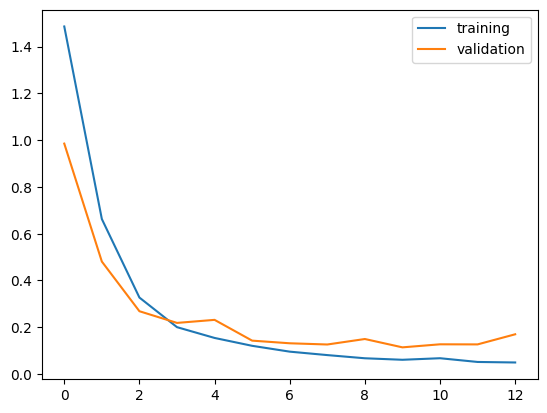

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()


Wide and Deep model 2
    This model uses two more deep layers

In [ ]:
# Function to create Keras model
def create_wide_deep_model2(input_dim):
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Wide part (shallow model, might just be one dense layer)
    wide_layer = Dense(16, activation='linear')(input_layer)
    
    # Deep part (deeper neural network with more layers)
    deep_layer = Dense(512, activation='relu')(input_layer)
    deep_layer = Dense(256, activation='relu')(deep_layer)
    deep_layer = Dense(128, activation='relu')(deep_layer)
    deep_layer = Dense(64, activation='relu')(deep_layer)
    deep_layer = Dense(32, activation='relu')(deep_layer)
    deep_layer = Dense(16, activation='relu')(deep_layer)
    
    # Combine the wide and deep parts (concatenate)
    combined = layers.add([wide_layer, deep_layer])

    #output
    output_layer = Dense(7, activation='softmax')(combined)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# Define Stratified KFold with 10 splits
kfold_for_validation = StratifiedKFold(n_splits=10)

# List to store validation metrics for each fold
val_losses = []
val_accuracies = []
rec_scores = []
# List to store the history at each
histories = []

# K-Fold Cross-Validation
for k, (train_idx, val_idx) in enumerate(kfold_for_validation.split(X,y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    # Create a new Keras model for each fold 
    model_2 = create_wide_deep_model2(X_train_fold.shape[1])
    
    # Use EarlyStopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model on the current fold
    history = model_2.fit(X_train_fold, y_train_fold, 
              validation_data=(X_val_fold, y_val_fold),
              epochs=50, 
              batch_size=32, 
              callbacks=[early_stopping], 
              verbose=0)
    histories.append(history)

    y_pred_probs2 = model_2.predict(X_val_fold)  # Predicted probabilities
    y_pred2 = np.argmax(y_pred_probs2, axis=1)  # Convert probabilities to class predictions


    print("Fold ", k)
    # Calculate recall
    recall = recall_score(y_val_fold, y_pred2, average='macro')  # Use 'macro' for multiclass recall
    rec_scores.append(recall)
    print("Recall:", recall)
    
    # Evaluate the model on the validation set of the current fold
    val_loss, val_accuracy = model_2.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Fold Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Calculate average performance metrics across all folds
avg_rec = np.mean(rec_scores)
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)
print(f"Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}")
print("Average Recall Score: ", avg_rec)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold  0
Recall: 0.8319284802043424
Fold Validation Loss: 0.5101, Validation Accuracy: 0.8349
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold  1
Recall: 0.8965152344462689
Fold Validation Loss: 0.2705, Validation Accuracy: 0.9005
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold  2
Recall: 0.9164203612479475
Fold Validation Loss: 0.2177, Validation Accuracy: 0.9194
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold  3
Recall: 0.9610707118096281
Fold Validation Loss: 0.1288, Validation Accuracy: 0.9621
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold  4
Recall: 0.9458128078817735
Fold Validation Loss: 0.1172, Validation Accuracy: 0.9479
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Fold  5
Recall: 0.9762139338494019
Fold Validation Loss: 0.0775, Validation Accuracy: 0.9763
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold  6
Recall: 0.9655172413793104
Fold Validation Loss: 0.0812, Validation Accuracy: 0.9668
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold  7
Recall: 0.9699155524278676
Fold Valida

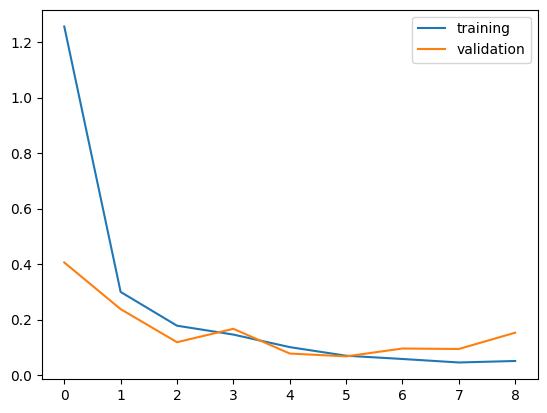

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()


Wide and Deep model 3
    This model uses less deep layers

In [ ]:
def create_wide_deep_model3(input_dim):
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Wide part (shallow model, might just be one dense layer)
    wide_layer = Dense(16, activation='linear')(input_layer)
    
    # Deep part (deeper neural network with more layers)
    deep_layer = Dense(32, activation='relu')(input_layer)
    deep_layer = Dense(16, activation='relu')(deep_layer)
    
    # Combine the wide and deep parts (concatenate)
    combined = layers.add([wide_layer, deep_layer])

    #output
    output_layer = Dense(7, activation='softmax')(combined)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# Define Stratified KFold with 10 splits
kfold_for_validation = StratifiedKFold(n_splits=10)

# List to store validation metrics for each fold
val_losses = []
val_accuracies = []
# List to store the history at each
histories = []
rec_scores = []

# K-Fold Cross-Validation
for k, (train_idx, val_idx) in enumerate(kfold_for_validation.split(X,y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    # Create a new Keras model for each fold 
    model_3 = create_wide_deep_model3(X_train_fold.shape[1])
    
    # Use EarlyStopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model on the current fold
    history = model_3.fit(X_train_fold, y_train_fold, 
              validation_data=(X_val_fold, y_val_fold),
              epochs=50, 
              batch_size=32, 
              callbacks=[early_stopping], 
              verbose=0)
    histories.append(history)

    y_pred_probs3 = model_3.predict(X_val_fold)  # Predicted probabilities
    y_pred3 = np.argmax(y_pred_probs3, axis=1)  # Convert probabilities to class predictions


    
    recall = recall_score(y_val_fold, y_pred3, average='macro')  # Use 'macro' for multiclass recall
    rec_scores.append(recall)
    print("Recall:", recall)
    # Evaluate the model on the validation set of the current fold
    val_loss, val_accuracy = model_3.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Fold Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Calculate average performance metrics across all folds

avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)
print(f"Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}")
print("Average Recall Score: ", avg_rec)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.7477782753644823
Fold Validation Loss: 0.6932, Validation Accuracy: 0.7500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.7829645268068913
Fold Validation Loss: 0.5505, Validation Accuracy: 0.7915
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Recall: 0.91673573644017
Fold Validation Loss: 0.2148, Validation Accuracy: 0.9194
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.9651523444626893
Fold Validation Loss: 0.1334, Validation Accuracy: 0.9668
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.9802955665024632
Fold Validation Loss: 0.0961, Validation Accuracy: 0.9810
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.9811400422237861
Fold Validation Loss: 0.1015, Validation Accuracy: 0.9810
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.9901477832512315
Fold Validation Loss: 0.0766, Validation Accuracy: 0.9905
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Recall: 0.9623309093752443
Fold Validation Loss: 0.1242, Validation Accuracy: 0.9621
7/7 ━━━━━━━━━━━━━━

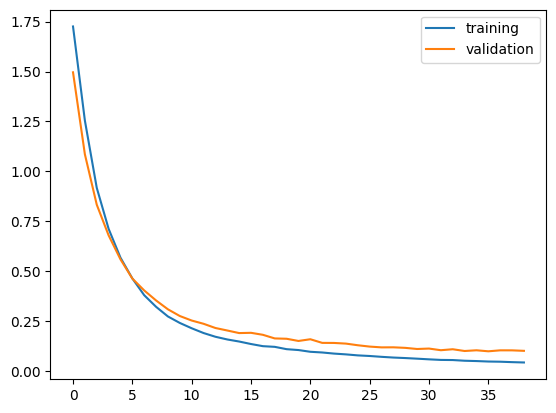

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()


No Wide, Only Deep model

This is the same as the original model but without any wide layers

In [ ]:
def create_deep_model(input_dim):
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Wide part (shallow model, might just be one dense layer)
    # wide_layer = Dense(64, activation='relu')(input_layer)
    
    # Deep part (deeper neural network with more layers)
    deep_layer = Dense(128, activation='relu')(input_layer)
    deep_layer = Dense(64, activation='relu')(deep_layer)
    deep_layer = Dense(32, activation='relu')(deep_layer)
    
    # Combine the wide and deep parts (concatenate)
    # combined = Dense(16, activation='relu')(wide_layer)  # Can also combine here
    output_layer = Dense(7, activation='softmax')(deep_layer)  # Output layer
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# Define Stratified KFold with 10 splits
kfold_for_validation = StratifiedKFold(n_splits=10)

# List to store validation metrics for each fold
val_losses = []
val_accuracies = []
# List to store the history at each
histories = []
auc_scores_deep = []
rec_scores = []

# K-Fold Cross-Validation
for k, (train_idx, val_idx) in enumerate(kfold_for_validation.split(X,y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    # Create a new Keras model for each fold 
    model_noWide = create_deep_model(X_train_fold.shape[1])
    
    # Use EarlyStopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model on the current fold
    history = model_noWide.fit(X_train_fold, y_train_fold, 
              validation_data=(X_val_fold, y_val_fold),
              epochs=50, 
              batch_size=32, 
              callbacks=[early_stopping], 
              verbose=0)
    histories.append(history)

    y_pred_prob_deep = model_noWide.predict(X_val_fold)  # Predicted probabilities
    y_pred_deep = np.argmax(y_pred_prob_deep, axis=1)
    
    auc_fold_deep = roc_auc_score(y_val_fold, y_pred_prob_deep, multi_class='ovr', average='macro')
    auc_scores_deep.append(auc_fold_deep)

    recall = recall_score(y_val_fold, y_pred_deep, average='macro')  # Use 'macro' for multiclass recall
    rec_scores.append(recall)
    print("Recall:", recall)
    # Evaluate the model on the validation set of the current fold
    val_loss, val_accuracy = model_noWide.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Fold Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Calculate average performance metrics across all folds
avg_rec = np.mean(rec_scores)
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)
print("Average Recall Score: ", avg_rec)
print(f"Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.7870148825813851
Fold Validation Loss: 0.4958, Validation Accuracy: 0.7925
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.8728803398754137
Fold Validation Loss: 0.3066, Validation Accuracy: 0.8768
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.9462923866864754
Fold Validation Loss: 0.1418, Validation Accuracy: 0.9479
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.9709229285583965
Fold Validation Loss: 0.0995, Validation Accuracy: 0.9716
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.9556650246305418
Fold Validation Loss: 0.1346, Validation Accuracy: 0.9573
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Recall: 0.9909922589725546
Fold Validation Loss: 0.0636, Validation Accuracy: 0.9905
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.9848567779602263
Fold Validation Loss: 0.0775, Validation Accuracy: 0.9858
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Recall: 0.9801196340605208
Fold Validation Loss: 0.0512, Validation Accuracy: 0.9810
7/7 ━━━━━━━━━━━━

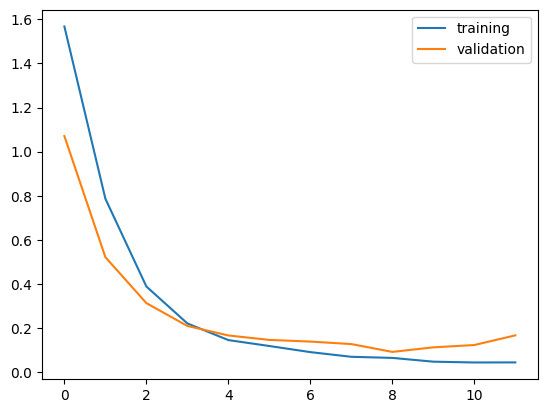

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()


our model1 had the best performance

In [ ]:
from sklearn.metrics import roc_auc_score

avg_auc_scores_wide_deep = np.mean(auc_scores_model1)
avg_auc_scores_deep = np.mean(auc_scores_deep)
print(avg_auc_scores_deep)
print(avg_auc_scores_wide_deep)


auc_wide_deep = roc_auc_score(y_val_fold, y_pred_probs, multi_class='ovr', average='macro')
auc_mlp = roc_auc_score(y_val_fold, y_pred_prob_deep, multi_class='ovr', average='macro')

print(f"Wide & Deep Model AUC: {auc_wide_deep:.4f}")
print(f"MLP Model AUC: {auc_mlp:.4f}")


0.9962778369410976
0.9965258563298081
Wide & Deep Model AUC: 0.9989
MLP Model AUC: 0.9995


In [ ]:
from scipy import stats

# Suppose auc_wide_deep and auc_mlp are arrays of AUC scores for each fold
t_stat, p_value = stats.ttest_rel(auc_scores_model1, auc_scores_deep)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")


T-statistic: 0.2148
P-value: 0.8347


The AUC score will range between 0 and 1 depending on the performance of the model. The ROC AUC score represents the area under the ROC Curve, which plots the true positive rate over the false positive rate. 

Because this is multiclass classification, we use multi_class = ovr, which means that the ROC AUC will be calculated with the one versus rest approach, meaning each class is ___ as a seperate binary classification task and the AUC score will be computed for each class. The average AUC score for each class will then be calculated. Because of the ovr ,,,,,, we will get the average AUC scores where each class is weighted equally. This works nicely because the classes are pretty evenly distributed, meaning there are no underrepresebted classes 

The  closer the AUC score is to 1.0, the better the model is performing. That being said, both our wide and deep model and the just deep model are performing very well, both having AUC scores over .99. 

The T statistic is used to measure the difference in means of two sets of numbers. As we knew from looking at teh AVG AUC scores for both models, they scores are very similar, so the T statistic is low, meaning there is not that much of a difference between the performance of the two models. 

The p-value is used to determine if the difference in performance of the two models is statstically significant. This means that it tells us if the models performance is actually different, or if the performance of one is only better than the other due to the choice of samples taken, and that if the test was repeated on a different subset of data, it is possible that the other model would have a better performance. 

Our null hypothesis is that the model's AUC scores are statistically different. I choose a ___ value of .05, which is the standard choice. Because the p-value is much higher than the ---, meaning that we fail to reject the null hypothesis and there is not sufficient evidence to conclude that AUC scores of the models are significantly different.

This means that we can conclude that although the average AUC score for the Wide and deep model is higher than that of the Deep model, we cannot definitively say that the performance of the Wide and Deep model is better (--- that we are judging the performance on AUC)

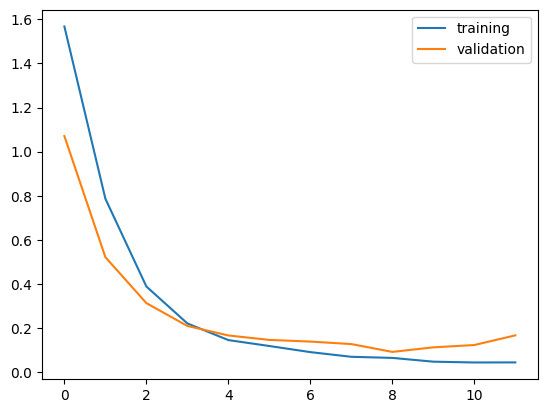

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()
